In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install requests beautifulsoup4 pandas matplotlib scikit-learn

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# For Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Ensure inline plotting
%matplotlib inline

# Set default figure size for better visibility
plt.rcParams['figure.figsize'] = [12, 8]


In [ ]:
# Update the path to your dataset
dataset_path = '/content/drive/MyDrive/ML/student_dataset_with_placement.xlsx'  # Adjust this path if necessary

# Load the dataset
df = pd.read_excel(dataset_path)

# Handle missing values
df.fillna(-1, inplace=True)

# Remove duplicates
df.drop_duplicates(subset=['roll_number'], keep='first', inplace=True)

# Add DSA platform columns if not present
if 'codeforces_max_rating' not in df.columns:
    df['codeforces_max_rating'] = 0
if 'codechef_highest_rating' not in df.columns:
    df['codechef_highest_rating'] = 0
if 'leetcode_ranking' not in df.columns:
    df['leetcode_ranking'] = float('inf')  # Use infinity if ranking is not available


In [ ]:
# Define features and target variable
features = ['sem1_1', 'sem1_2', 'sem2_1', 'sem2_2',
            'overall_cgpa', 'no_of_backlogs', 'no_of_projects',
            'codeforces_max_rating', 'codechef_highest_rating', 'leetcode_ranking']

df['placement_status'] = df['placement_status'].fillna(-1)
label_encoder = LabelEncoder()
df['placement_status_encoded'] = label_encoder.fit_transform(df['placement_status'])


In [ ]:
# Prepare feature matrix X and target vector y
X = df[features]
y = df['placement_status_encoded']

# Handle infinite values in X
X.replace([float('inf'), -float('inf')], -1, inplace=True)


<ipython-input-6-73f910b90382>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([float('inf'), -float('inf')], -1, inplace=True)


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [ ]:
# Initialize and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print dataset sizes
print("Total Dataset Size:", len(X))
print("Training Dataset Size:", len(X_train))
print("Testing Dataset Size:", len(X_test))

Total Dataset Size: 31
Training Dataset Size: 24
Testing Dataset Size: 7


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
# Predictions
y_pred = model.predict(X_test)

# Model evaluation
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



Model Accuracy: 0.8571428571428571
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.83      0.91         6

    accuracy                           0.86         7
   macro avg       0.75      0.92      0.79         7
weighted avg       0.93      0.86      0.87         7



In [ ]:
def extract_username(url):
    # Remove any trailing slash and extract the username
    url = url.rstrip('/')
    username = url.split('/')[-1]
    return username


In [ ]:
def get_codeforces_data(username):
    user_info_url = f'https://codeforces.com/api/user.info?handles={username}'
    try:
        response = requests.get(user_info_url)
        response.raise_for_status()
        data = response.json()
        if data['status'] == 'OK':
            user_info = data['result'][0]
            current_rating = int(user_info.get('rating', 0))
            max_rating = int(user_info.get('maxRating', 0))
        else:
            print("Error fetching Codeforces data.")
            current_rating = 0
            max_rating = 0
    except Exception as e:
        print(f"Error fetching Codeforces data: {e}")
        current_rating = 0
        max_rating = 0
    return {
        'platform': 'Codeforces',
        'current_rating': current_rating,
        'max_rating': max_rating
    }


In [ ]:
def get_codechef_data(username):
    url = f'https://www.codechef.com/users/{username}'
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extract current rating
        rating_number = soup.find('div', class_='rating-number')
        current_rating = int(rating_number.text.strip()) if rating_number else 0

        # Extract highest rating
        rating_header = soup.find('div', class_='rating-header')
        highest_rating_tag = rating_header.find('small') if rating_header else None
        highest_rating = int(re.search(r'\d+', highest_rating_tag.text).group()) if highest_rating_tag else 0
    except Exception as e:
        print(f"Error fetching CodeChef data: {e}")
        current_rating = 0
        highest_rating = 0
    return {
        'platform': 'CodeChef',
        'current_rating': current_rating,
        'highest_rating': highest_rating
    }


In [ ]:
def get_leetcode_data(username):
    url = 'https://leetcode.com/graphql'
    headers = {
        'Content-Type': 'application/json',
        'Referer': f'https://leetcode.com/{username}/',
        'User-Agent': 'Mozilla/5.0'
    }
    query = '''
    query getUserProfile($username: String!) {
      matchedUser(username: $username) {
        username
        submitStatsGlobal {
          acSubmissionNum {
            difficulty
            count
          }
        }
        profile {
          ranking
        }
      }
    }
    '''
    variables = {"username": username}
    payload = {
        "operationName": "getUserProfile",
        "variables": variables,
        "query": query
    }
    try:
        response = requests.post(url, json=payload, headers=headers)
        response.raise_for_status()
        result = response.json()
        if not result.get('data') or not result['data'].get('matchedUser'):
            print("Error fetching LeetCode data.")
            return {
                'platform': 'LeetCode',
                'total_solved': 0,
                'problems_by_difficulty': {},
                'ranking': float('inf')
            }

        submission_stats = result['data']['matchedUser']['submitStatsGlobal']['acSubmissionNum']
        total_solved = sum(item['count'] for item in submission_stats if item['difficulty'] != 'All')
        problems_by_difficulty = {
            item['difficulty']: item['count'] for item in submission_stats if item['difficulty'] != 'All'
        }
        ranking = result['data']['matchedUser']['profile'].get('ranking', None)
        if ranking is not None:
            ranking = int(ranking)
        else:
            ranking = float('inf')  # Use infinity if ranking is not available
    except Exception as e:
        print(f"Error fetching LeetCode data: {e}")
        total_solved = 0
        problems_by_difficulty = {}
        ranking = float('inf')
    return {
        'platform': 'LeetCode',
        'total_solved': total_solved,
        'problems_by_difficulty': problems_by_difficulty,
        'ranking': ranking
    }


In [ ]:
def plot_leetcode_performance(leetcode_data):
    # Plotting LeetCode Problem Solving Performance as Bar Chart
    easy = leetcode_data['problems_by_difficulty'].get('Easy', 0)
    medium = leetcode_data['problems_by_difficulty'].get('Medium', 0)
    hard = leetcode_data['problems_by_difficulty'].get('Hard', 0)

    difficulties = ['Easy', 'Medium', 'Hard']
    problems_solved = [easy, medium, hard]
    bars = plt.bar(difficulties, problems_solved, color=['#90EE90', '#FFD700', '#FF6347'])
    plt.title('LeetCode Problem Solving Performance', fontsize=18)
    plt.xlabel('Difficulty Level', fontsize=14)
    plt.ylabel('Number of Problems Solved', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add labels on top of each bar
    max_ps = max(problems_solved) if max(problems_solved) > 0 else 1
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + max_ps*0.01, int(yval), ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_platform_ratings(codeforces_data, codechef_data, leetcode_data):
    # Prepare Data for Plotting
    platforms = ['Codeforces', 'CodeChef', 'LeetCode']
    ratings = [
        codeforces_data['current_rating'],
        codechef_data['current_rating'],
        leetcode_data['ranking']  # Using ranking as 'rating' for LeetCode
    ]

    # Handle cases where rankings are infinite
    ratings = [r if r != float('inf') else 0 for r in ratings]

    # Plotting Ratings as Line Graph
    plt.figure()
    plt.plot(platforms, ratings, marker='o', linestyle='-', color='blue')
    plt.title('Current Ratings Across Platforms', fontsize=18)
    plt.xlabel('Platforms', fontsize=14)
    plt.ylabel('Ratings/Ranking', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Annotate each point with its rating value
    for x, y in zip(platforms, ratings):
        plt.text(x, y + max(ratings)*0.01, f"{y}", ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()


In [ ]:
def evaluate_dsa_performance(codeforces_data, codechef_data, leetcode_data):
    max_rating_cf = codeforces_data.get('max_rating', 0)
    highest_rating_cc = codechef_data.get('highest_rating', 0)
    leetcode_ranking = leetcode_data.get('ranking', float('inf'))

    # Conditions for DSA proficiency
    if (max_rating_cf >= 1600 and highest_rating_cc >= 1800 and leetcode_ranking <= 10000):
        print("\nYOU HAVE A STRONG GRASP OF DSA; KEEP HONING THAT SKILL WHILE MAINTAINING BALANCE IN OTHER AREAS. YOUR PLACEMENT IS A TESTAMENT TO YOUR EFFORTS!")
    elif (max_rating_cf >= 800 and highest_rating_cc >= 1000 and leetcode_ranking <= 300000):
        print("\nYOU ARE PROFICIENT IN DSA AND HAVE REFINED YOUR SKILLS FURTHER IN PREPARATION FOR THE UPCOMING PLACEMENT DRIVE.")
    else:
        print("\nYOU ARE NOT PROFICIENT IN DSA AND REQUIRE SUBSTANTIAL IMPROVEMENT IN DSA AND PROBLEM-SOLVING SKILLS.")


In [ ]:
def plot_academic_performance(sem1_1, sem1_2, sem2_1, sem2_2):
    # Academic Performance Line Graph
    semesters = ['Sem1-1', 'Sem1-2', 'Sem2-1', 'Sem2-2']
    cgpa_values = [sem1_1, sem1_2, sem2_1, sem2_2]

    plt.figure()
    plt.plot(semesters, cgpa_values, marker='o', linestyle='-', color='#1E90FF')
    plt.title('Academic Performance (CGPA)', fontsize=18)
    plt.xlabel('Semester', fontsize=14)
    plt.ylabel('CGPA', fontsize=14)
    plt.ylim(0, 10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Annotate each point with its CGPA value
    for x, y in zip(semesters, cgpa_values):
        plt.text(x, y + 0.1, f"{y:.2f}", ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()


In [ ]:
def evaluate_academic_performance(cgpa, backlogs):
    if cgpa >= 8.50:
        print("\nYour academic performance is good; it's enough for placements.")
    elif 8.00 <= cgpa < 8.50:
        required_improvement = 8.50 - cgpa
        print(f"\nYou should improve your CGPA by {required_improvement:.2f} before your placement drives.")
    else:
        required_improvement = 8.50 - cgpa
        print(f"\nYou must improve your CGPA by {required_improvement:.2f} before your placement drives. You only have limited time!")

    if backlogs > 0:
        print("You must clear your backlogs and improve your CGPA to 8.5.")


In [ ]:
def evaluate_projects(projects):
    if projects >= 5:
        print("\nYou have good project experience.")
    elif 3 <= projects < 5:
        print("\nYou're doing okay, but focus a bit more on your projects.")
    else:
        print("\nYou must focus on your projects and complete more before your placement drives come.")


In [ ]:
def calculate_custom_probability(cgpa, backlogs, projects, codeforces_data, codechef_data, leetcode_data):
    # Adjusted Weights to Increase Probability
    # Normalize CGPA Score
    cgpa_score = (cgpa / 10) * 100  # Out of 100
    cgpa_weighted = cgpa_score * 0.5  # Increased weight from 0.4 to 0.5

    # Normalize Backlogs Score
    max_backlogs = 5
    backlogs = min(backlogs, max_backlogs)
    backlogs_score = ((max_backlogs - backlogs) / max_backlogs) * 100  # Out of 100
    backlogs_weighted = backlogs_score * 0.05  # Reduced negative impact

    # Normalize Projects Score
    max_projects = 5
    projects = min(projects, max_projects)
    projects_score = (projects / max_projects) * 100  # Out of 100
    projects_weighted = projects_score * 0.25  # Increased weight from 0.2 to 0.25

    # Normalize DSA Proficiency Score
    # Codeforces
    cf_max_rating = codeforces_data.get('max_rating', 0)
    cf_score = (cf_max_rating / 2500) * 100  # Adjusted max rating to 2500

    # CodeChef
    cc_highest_rating = codechef_data.get('highest_rating', 0)
    cc_score = (cc_highest_rating / 2500) * 100  # Adjusted max rating to 2500

    # LeetCode
    lc_ranking = leetcode_data.get('ranking', float('inf'))
    max_ranking = 300000  # Adjusted max ranking to 300,000
    if lc_ranking == float('inf') or lc_ranking > max_ranking:
        lc_score = 0
    else:
        lc_score = ((max_ranking - lc_ranking) / max_ranking) * 100

    # Average DSA Score
    dsa_score = (cf_score + cc_score + lc_score) / 3
    dsa_weighted = dsa_score * 0.2  # Decreased weight from 0.3 to 0.2

    # Total Placement Probability
    total_probability = cgpa_weighted + backlogs_weighted + projects_weighted + dsa_weighted

    # Ensure the probability is between 0 and 100
    total_probability = max(0, min(total_probability, 100))

    # Round the probability to two decimal places
    total_probability = round(total_probability, 2)

    return total_probability


In [ ]:
def suggest_package(probability):
    if probability >= 90:
        package_suggestion = "You are suited for top-tier packages (>15 LPA)."
    elif 75 <= probability < 90:
        package_suggestion = "You are suited for mid-tier packages (10-15 LPA)."
    elif 60 <= probability < 75:
        package_suggestion = "You are suited for entry-level packages (5-10 LPA)."
    else:
        package_suggestion = "You might need to improve your skills to secure better packages."
    return package_suggestion


In [ ]:
def provide_improvement_suggestions(target_package, current_probability, backlogs):
    package_probabilities = {
        'entry': 60,
        'mid': 75,
        'top': 90
    }
    required_probability = package_probabilities.get(target_package, 0)
    gap = required_probability - current_probability

    suggestions = []
    if gap <= 0:
        suggestions.append("You are on track for your desired package!")
    else:
        suggestions.append(f"You need to increase your placement probability by {gap:.2f}% to reach your desired package.")

        # Suggest focus areas based on scores
        suggestions.append("Consider improving in the following areas:")
        if current_probability < required_probability:
            suggestions.append("- Enhance your DSA skills through practice and contests.")
        if current_probability < required_probability - 5:
            suggestions.append("- Work on more projects to showcase practical experience.")
        if current_probability < required_probability - 10:
            suggestions.append("- Aim to increase your CGPA by focusing on academics.")
        if current_probability < required_probability - 15 and backlogs > 0:
            suggestions.append("- Clear any existing backlogs.")

    return suggestions


In [ ]:
def bablu():
    name = input("Enter Student Name: ").strip()
    roll_number = input("Enter Roll Number: ").strip()
    leetcode_url = input("Enter LeetCode Profile URL: ").strip()
    codechef_url = input("Enter CodeChef Profile URL: ").strip()
    codeforces_url = input("Enter Codeforces Profile URL: ").strip()

    # Extract usernames from URLs
    codeforces_username = extract_username(codeforces_url)
    codechef_username = extract_username(codechef_url)
    leetcode_username = extract_username(leetcode_url)

    # Fetch DSA platform data
    codeforces_data = get_codeforces_data(codeforces_username)
    codechef_data = get_codechef_data(codechef_username)
    leetcode_data = get_leetcode_data(leetcode_username)

    sem1_1 = float(input("Enter CGPA for Sem1-1: ").strip())
    sem1_2 = float(input("Enter CGPA for Sem1-2: ").strip())
    sem2_1 = float(input("Enter CGPA for Sem2-1: ").strip())
    sem2_2 = float(input("Enter CGPA for Sem2-2: ").strip())
    cgpa = float(input("Enter Overall CGPA: ").strip())
    backlogs = int(input("Enter Number of Backlogs: ").strip())
    projects = int(input("Enter Number of Projects: ").strip())

    # Prepare features for the model
    student_features = pd.DataFrame([[
        sem1_1, sem1_2, sem2_1, sem2_2, cgpa, backlogs, projects,
        codeforces_data.get('max_rating', 0),
        codechef_data.get('highest_rating', 0),
        leetcode_data.get('ranking', float('inf'))
    ]], columns=features)

    # Handle missing or infinity values
    student_features.replace([float('inf'), -float('inf')], -1, inplace=True)

    # Predict placement status using the model
    predicted_status_encoded = model.predict(student_features)[0]
    predicted_status = label_encoder.inverse_transform([predicted_status_encoded])[0]

    # Custom placement probability calculation
    probability = calculate_custom_probability(
        cgpa, backlogs, projects, codeforces_data, codechef_data, leetcode_data)

    # Suggest suitable package
    package_suggestion = suggest_package(probability)

    # Display Student Performance
    print("\nSTUDENT PERFORMANCE")
    print(f"Name: {name}")
    print(f"Roll Number: {roll_number}")
    print(f"LeetCode URL: {leetcode_url}")
    print(f"LeetCode Ranking: {leetcode_data.get('ranking', 'N/A')}")
    plot_leetcode_performance(leetcode_data)
    print(f"CodeChef URL: {codechef_url}")
    print(f"CodeChef Rating: {codechef_data['current_rating']}")
    print(f"Codeforces URL: {codeforces_url}")
    print(f"Codeforces Rating: {codeforces_data['current_rating']}")
    plot_platform_ratings(codeforces_data, codechef_data, leetcode_data)

    # Evaluate DSA Performance
    evaluate_dsa_performance(codeforces_data, codechef_data, leetcode_data)

    # Plot Academic Performance CGPA Graph
    plot_academic_performance(sem1_1, sem1_2, sem2_1, sem2_2)

    # Academic Performance Summary
    evaluate_academic_performance(cgpa, backlogs)

    # Projects Summary
    evaluate_projects(projects)

    # Display Predicted Placement Status
    print("\n")
    print(f"PREDICTED PLACEMENT STATUS BY MODEL: {predicted_status}".upper())

    # Display Placement Probability
    print(f"ESTIMATED PLACEMENT PROBABILITY: {probability:.2f}%".upper())

    # Display Package Suggestion
    print(f"\n{package_suggestion}")

    # Ask the student about their desired package
    print("\nWhich package are you interested in?")
    print("Options: Entry (5-10 LPA), Mid (10-15 LPA), Top (>15 LPA)")
    desired_package = input("Enter your desired package (entry/mid/top): ").strip().lower()

    # Provide improvement suggestions
    suggestions = provide_improvement_suggestions(desired_package, probability, backlogs)

    print("\nSuggestions for Improvement:")
    for suggestion in suggestions:
        print(suggestion)


Enter Student Name: Koduri Durga Prasad
Enter Roll Number: 22501A0586
Enter LeetCode Profile URL: https://leetcode.com/u/koduridurgaprasad2003/
Enter CodeChef Profile URL: https://www.codechef.com/users/durga_pasad
Enter Codeforces Profile URL: https://codeforces.com/profile/koduridurgaprasad2003
Enter CGPA for Sem1-1: 9.00
Enter CGPA for Sem1-2: 8.69
Enter CGPA for Sem2-1: 8.39
Enter CGPA for Sem2-2: 8.59
Enter Overall CGPA: 8.49
Enter Number of Backlogs: 0
Enter Number of Projects: 7

STUDENT PERFORMANCE
Name: Koduri Durga Prasad
Roll Number: 22501A0586
LeetCode URL: https://leetcode.com/u/koduridurgaprasad2003/
LeetCode Ranking: 302074


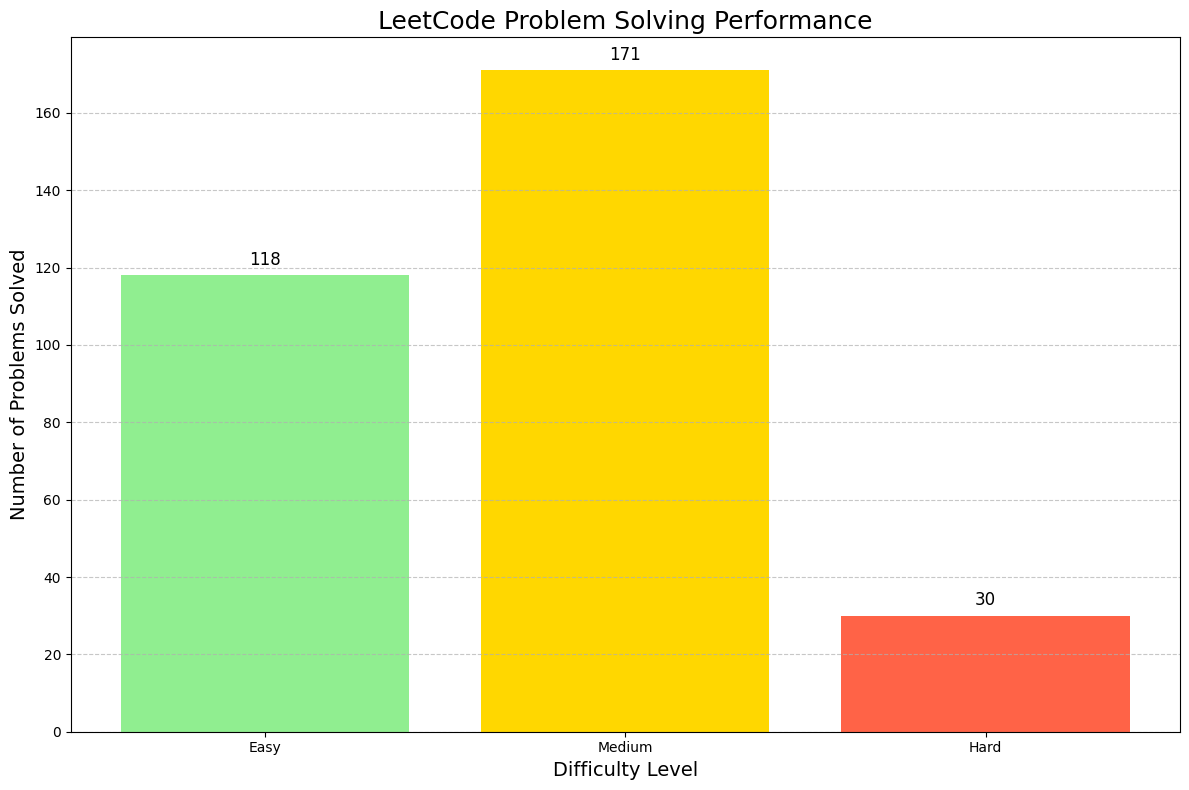

CodeChef URL: https://www.codechef.com/users/durga_pasad
CodeChef Rating: 987
Codeforces URL: https://codeforces.com/profile/koduridurgaprasad2003
Codeforces Rating: 885


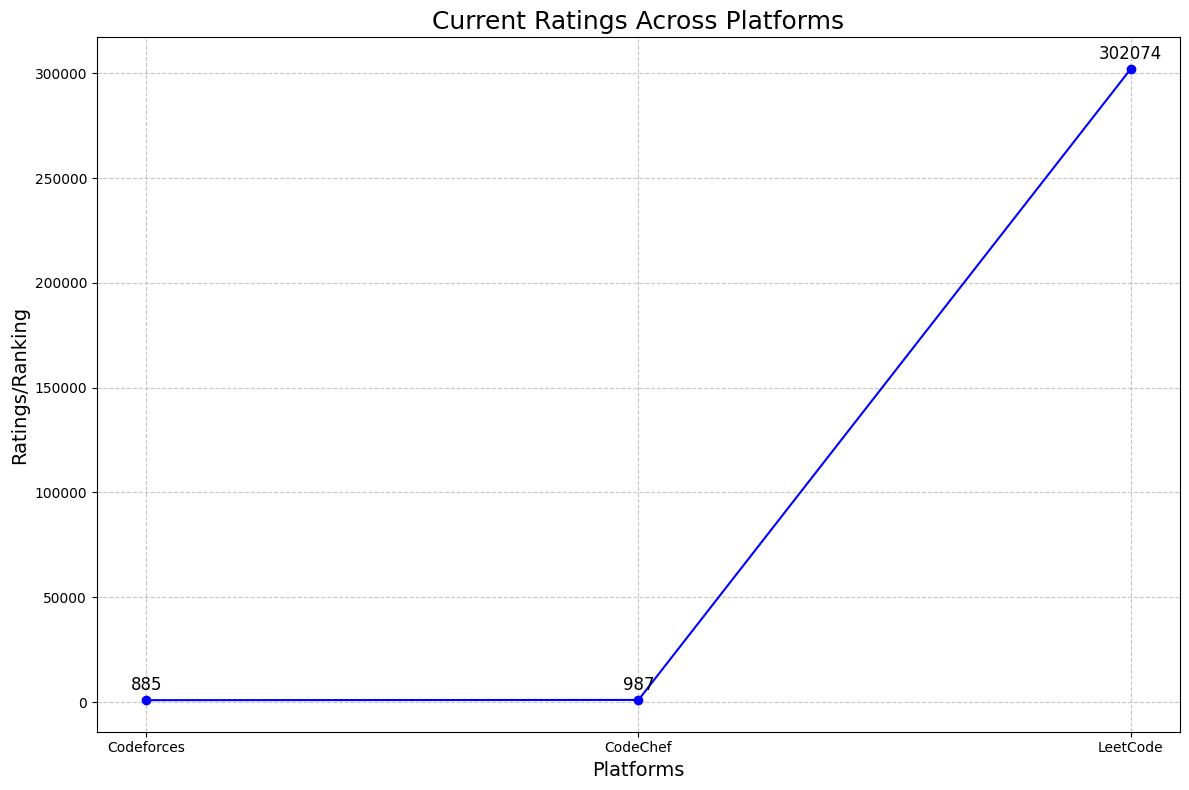


YOU ARE NOT PROFICIENT IN DSA AND REQUIRE SUBSTANTIAL IMPROVEMENT IN DSA AND PROBLEM-SOLVING SKILLS.


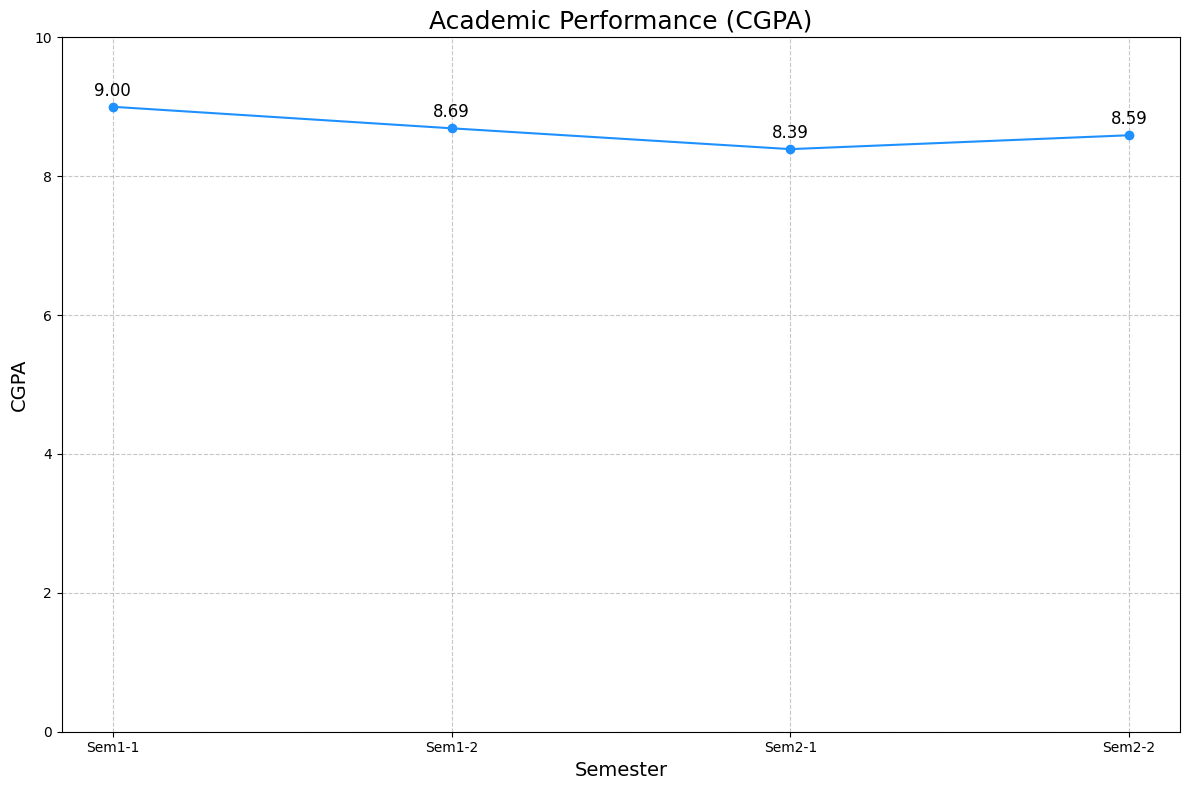


You should improve your CGPA by 0.01 before your placement drives.

You have good project experience.


PREDICTED PLACEMENT STATUS BY MODEL: PLACED
ESTIMATED PLACEMENT PROBABILITY: 77.93%

You are suited for mid-tier packages (10-15 LPA).

Which package are you interested in?
Options: Entry (5-10 LPA), Mid (10-15 LPA), Top (>15 LPA)
Enter your desired package (entry/mid/top): Entry

Suggestions for Improvement:
You are on track for your desired package!


In [ ]:
if __name__ == '__main__':
  bablu()